# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from ryp import r, to_py

In [3]:
r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [4]:
columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

In [5]:
def polys_to_df(polys):
    poly_labels = list(polys)
    poly_coords = list(polys.values())
    poly_coord_dim = np.shape(poly_coords[0])[-1]
    poly_df = pd.concat(
        [
            pd.DataFrame(
                poly_coords[i], columns=[f"V{i}" for i in range(poly_coord_dim)]
            ).assign(vertex=lambda df: df.index + 1, id=i, label=poly_labels[i])
            for i in range(len(polys))
        ],
        ignore_index=True,
    )
    return poly_df

In [6]:
poly_df = polys_to_df(polys)

In [7]:
columb["label"] = columb["district"]
poly_df = columb.merge(poly_df, on="label")

In [8]:
def plot_polys(df, color, polys, label):
    poly_df = polys_to_df(polys)
    df["label"] = df[label]
    plot_df = df.merge(poly_df, on="label")
    p = (
        p9.ggplot(plot_df)
        + p9.aes("V0", "V1", group="label", fill=color)
        + p9.geom_polygon()
    )
    return p

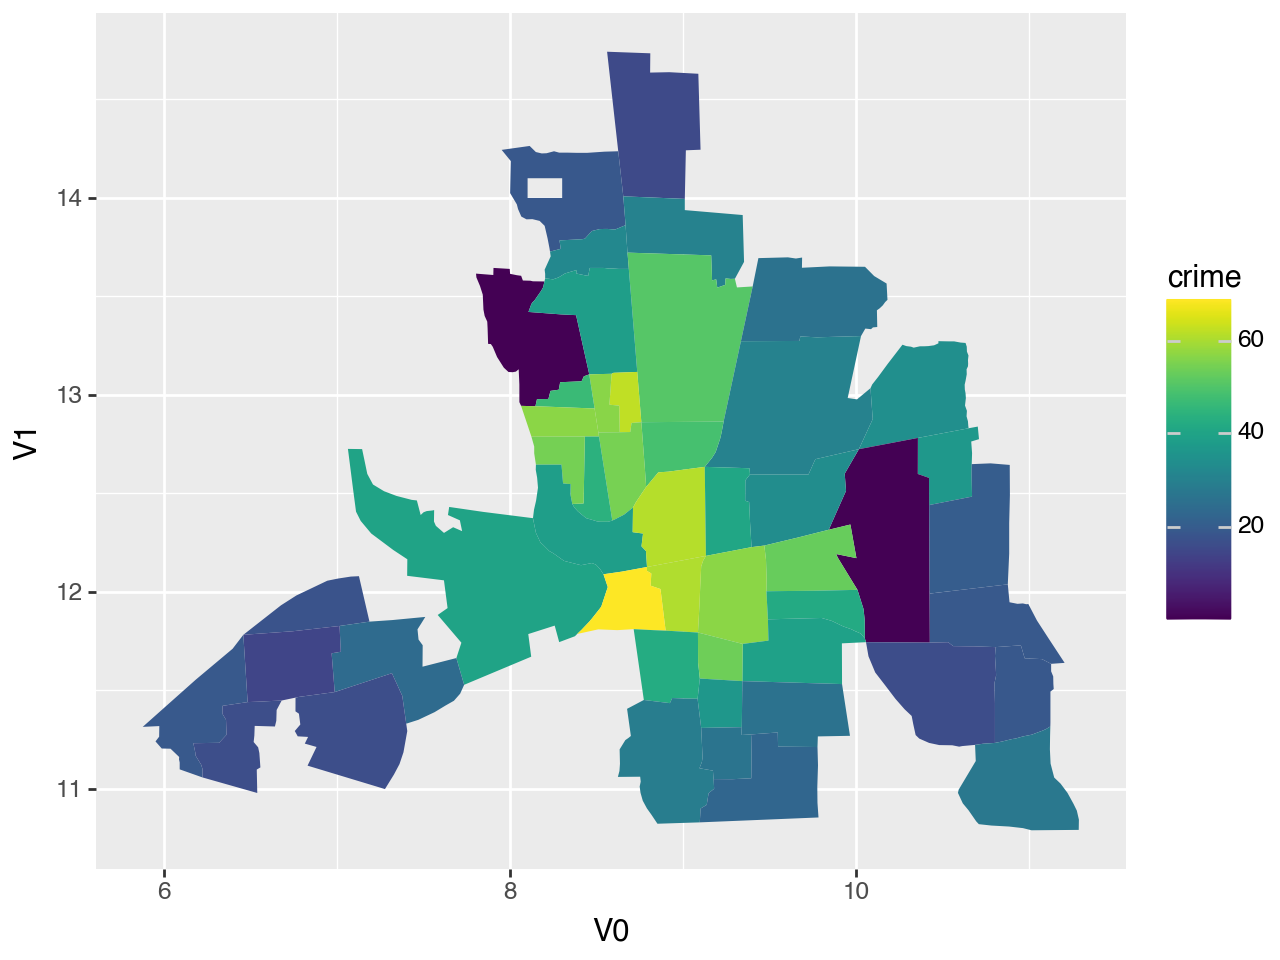

In [9]:
plot_polys(columb, "crime", polys, "district")

## Model Definition

### Setup response model

In [10]:
df = columb

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [11]:
tb = gam.TermBuilder.from_df(df)

In [12]:
loc += tb.rs("income", cluster="district", noncentered=True)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


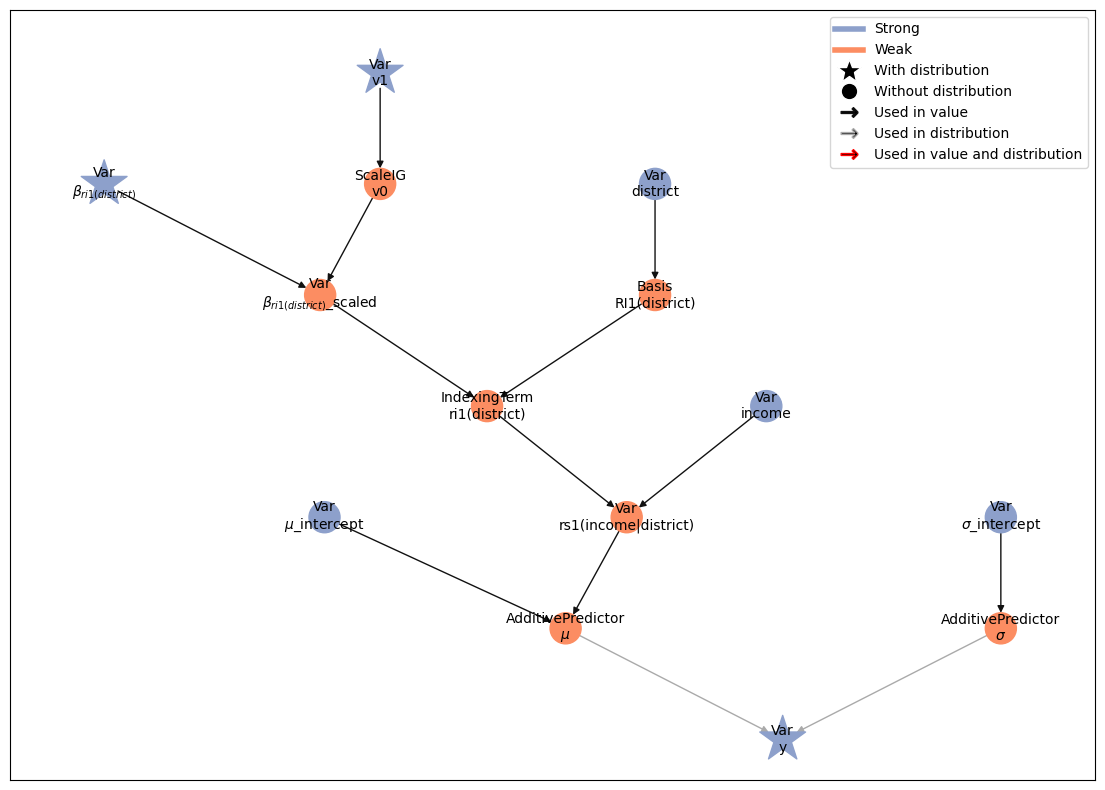

In [13]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [14]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{ri1(district)}$', 'v1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  6.09chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1972.86chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1398.57chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting

### MCMC summary

In [15]:
summary = gs.Summary(results)
summary

Parameter summary:

                                  kernel       mean        sd     q_0.05  \
parameter               index                                              
$\beta_{ri1(district)}$ (0,)   kernel_02  -0.302155  0.984721  -1.917585   
                        (1,)   kernel_02  -0.233986  0.981665  -1.810296   
                        (2,)   kernel_02  -0.068620  0.953493  -1.630181   
                        (3,)   kernel_02  -0.015690  0.990575  -1.632579   
                        (4,)   kernel_02   0.101238  0.964886  -1.516347   
                        (5,)   kernel_02  -0.137498  0.962041  -1.699056   
                        (6,)   kernel_02  -0.308762  1.055092  -2.049339   
                        (7,)   kernel_02   0.022577  0.941838  -1.504671   
                        (8,)   kernel_02  -0.062771  0.961544  -1.669871   
                        (9,)   kernel_02  -0.024762  0.986514  -1.670009   
                        (10,)  kernel_02   0.205557  1.017103  -1.473466   
                        (11,)  kernel_02   0.144018  0.996172  -1.508315   
                        (12,)  kernel_02   0.077025  0.966730  -1.530089   
                        (13,)  kernel_02   0.141249  0.975995  -1.457171   
                        (14,)  kernel_02   0.093166  0.983564  -1.512740   
                        (15,)  kernel_02   0.141063  1.007260  -1.536509   
                        (16,)  kernel_02  -0.018923  0.991719  -1.649004   
                        (17,)  kernel_02   0.064574  0.972077  -1.545785   
                        (18,)  kernel_02   0.153297  1.005837  -1.469567   
                        (19,)  kernel_02  -0.575300  0.995840  -2.169219   
                        (20,)  kernel_02   0.023239  0.971649  -1.561807   
                        (21,)  kernel_02  -0.024491  0.956893  -1.592010   
                        (22,)  kernel_02  -0.225336  0.957959  -1.792009   
                        (23,)  kernel_02  -0.006038  0.976818  -1.605466   
                        (24,)  kernel_02   0.187273  1.023613  -1.459918   
                        (25,)  kernel_02   0.036260  0.986744  -1.589388   
                        (26,)  kernel_02   0.152482  1.014748  -1.489527   
                        (27,)  kernel_02   0.135969  0.993416  -1.505066   
                        (28,)  kernel_02   0.182021  0.996789  -1.442233   
                        (29,)  kernel_02   0.338416  1.014929  -1.350088   
                        (30,)  kernel_02  -0.253881  0.974686  -1.807612   
                        (31,)  kernel_02  -0.208918  0.977002  -1.800202   
                        (32,)  kernel_02   0.058545  0.989055  -1.550131   
                        (33,)  kernel_02  -0.133464  0.988862  -1.749255   
                        (34,)  kernel_02   0.033315  0.966427  -1.562127   
                        (35,)  kernel_02  -0.255405  0.976303  -1.802593   
                        (36,)  kernel_02   0.035453  0.934786  -1.506883   
                        (37,)  kernel_02   0.156618  1.006603  -1.519621   
                        (38,)  kernel_02  -0.207333  0.973217  -1.801668   
                        (39,)  kernel_02  -0.342917  0.934698  -1.862056   
                        (40,)  kernel_02  -0.258018  0.976723  -1.808318   
                        (41,)  kernel_02  -0.275362  0.967247  -1.818342   
                        (42,)  kernel_02  -0.003823  0.968472  -1.605014   
                        (43,)  kernel_02  -0.107633  0.956048  -1.647243   
                        (44,)  kernel_02  -0.074355  0.979056  -1.679012   
                        (45,)  kernel_02  -0.253568  0.992310  -1.842330   
                        (46,)  kernel_02  -0.098045  0.972382  -1.663520   
                        (47,)  kernel_02  -0.044891  0.989063  -1.644966   
                        (48,)  kernel_02  -0.158925  0.973308  -1.742793   
$\mu$_intercept         ()     kernel_01  35.642735  2.655650  31.319125   
$\sigma$_intercept      ()  

## Plots

In [16]:
samples = results.get_posterior_samples()

In [17]:
from liesel_gam.plots import plot_regions, plot_forest

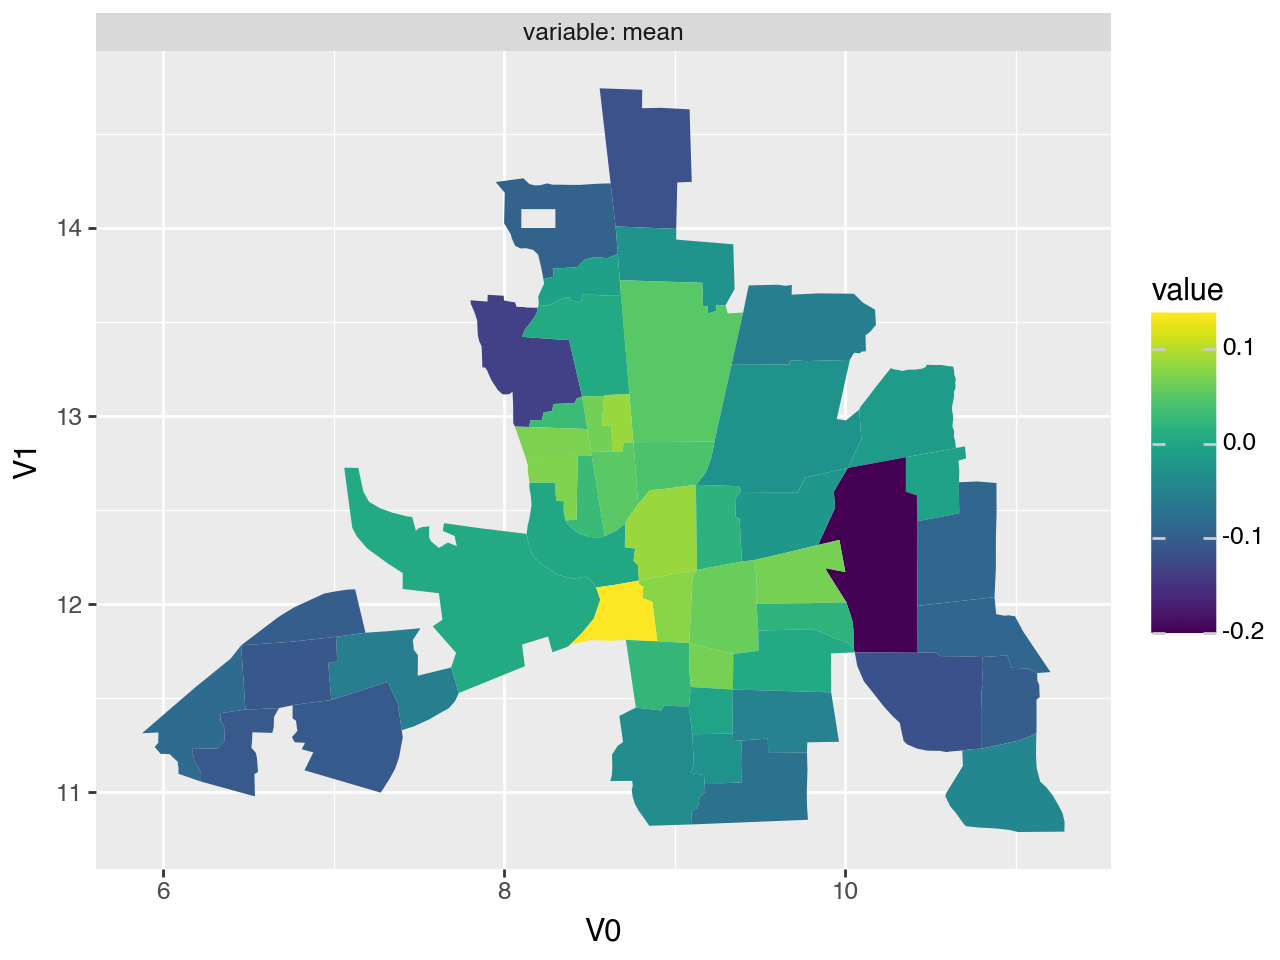

In [19]:
plot_regions(model.vars["ri1(district)"], samples, polys=polys)

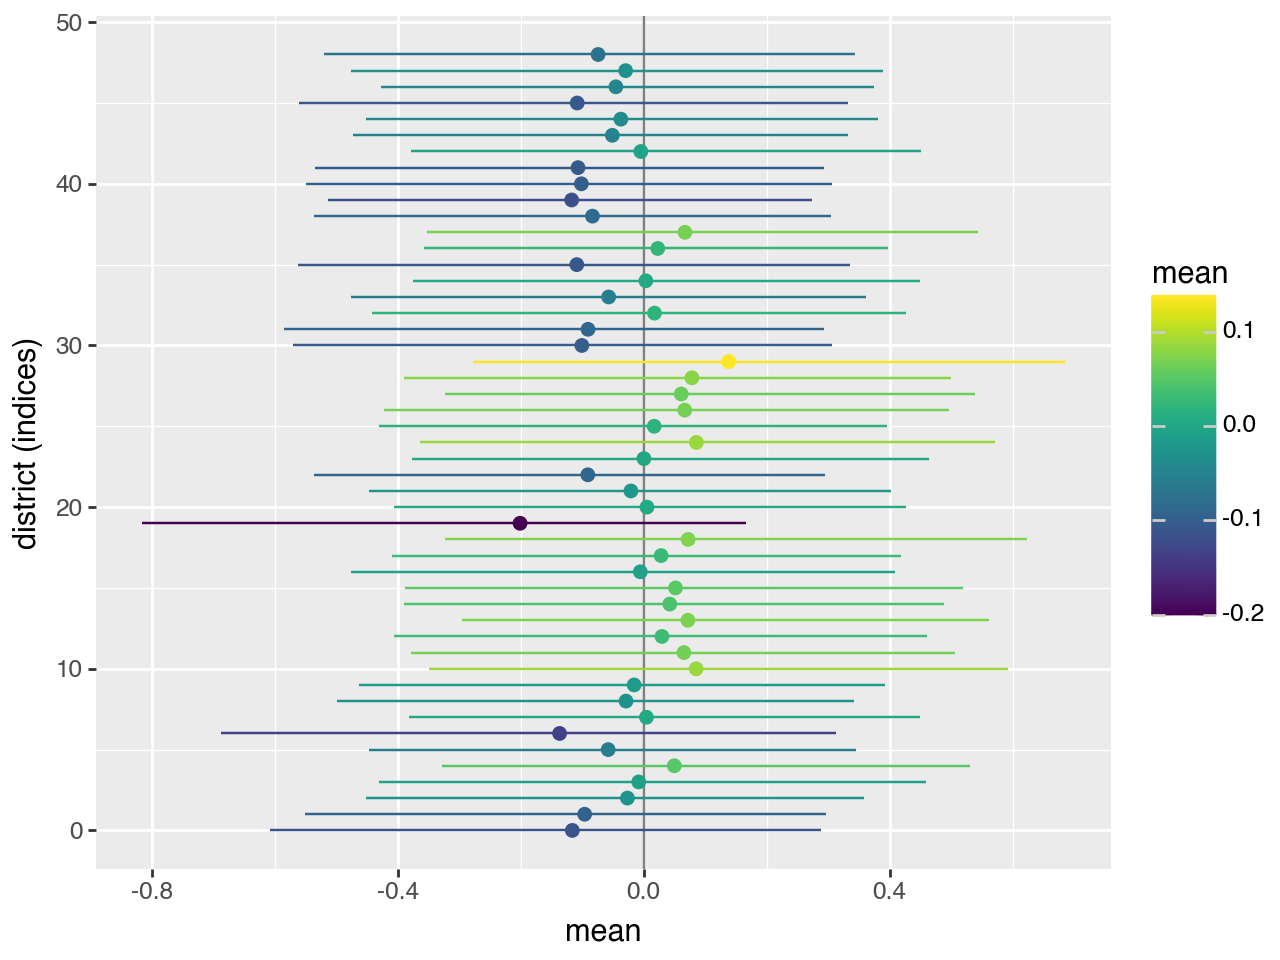

In [20]:
plot_forest(model.vars["ri1(district)"], samples)

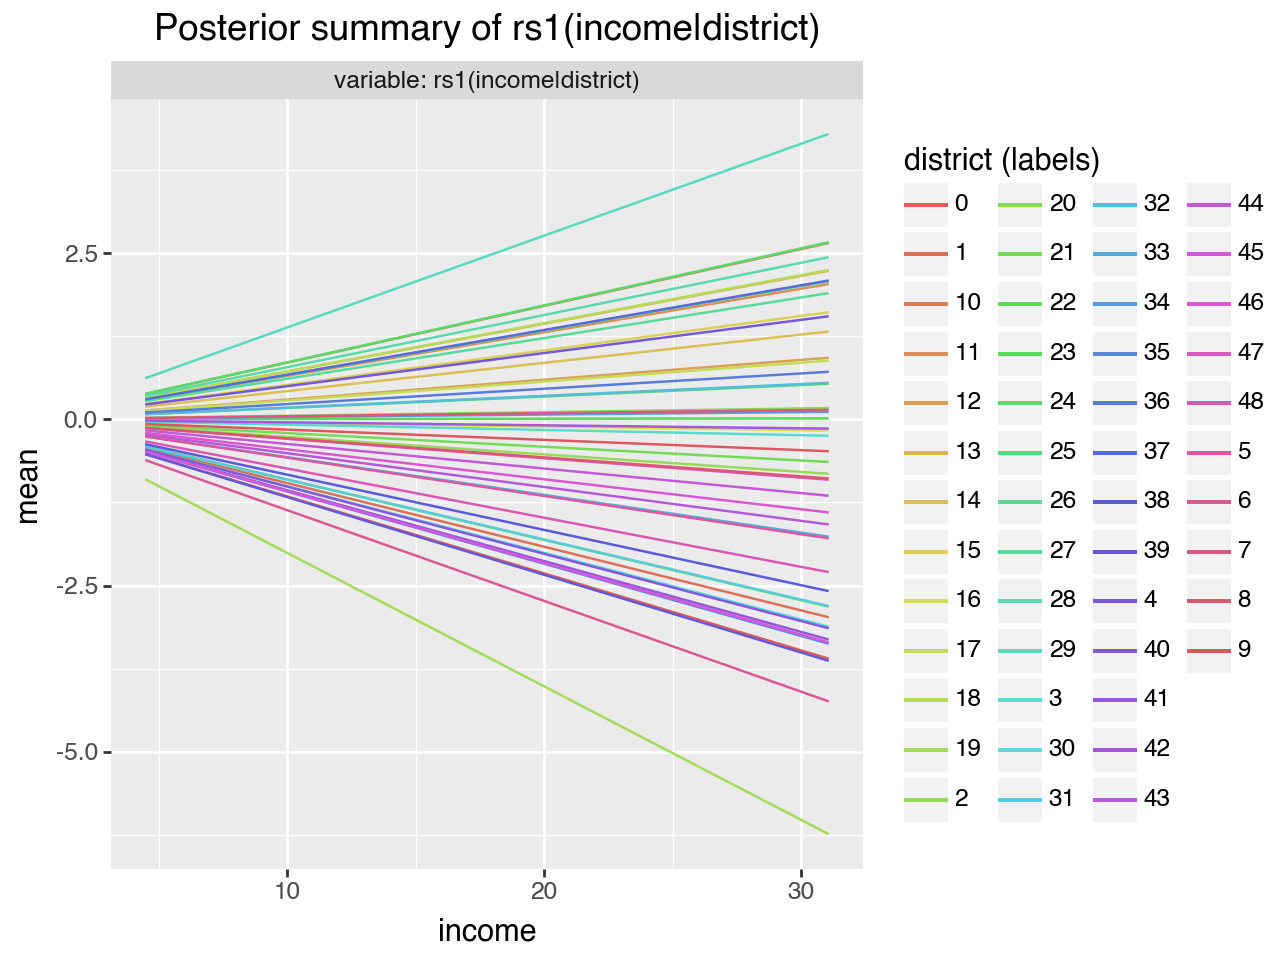

In [44]:
from liesel_gam.plots import (
    Literal,
    Term,
    Array,
    Sequence,
    input_grid_2d_smooth,
    grid_2d,
)

from liesel_gam.var import IndexingTerm

PlotVars = Literal[
    "mean", "sd", "var", "hdi_low", "hdi_high", "q_0.05", "q_0.5", "q_0.95"
]


def plot_2d_smooth(
    term: lsl.Var,
    x: lsl.Var,
    cluster: IndexingTerm,
    samples: dict[str, Array],
    ngrid: int = 150,
    newdata: gs.Position | None = None,
    plot_vars: PlotVars | Sequence[PlotVars] = "mean",
    ci_quantiles: tuple[float, float] | None = (0.05, 0.95),
    hdi_prob: float | None = None,
    labels: Sequence[str] | None = None,
):
    if isinstance(plot_vars, str):
        plot_vars = [plot_vars]

    if newdata is None:
        xgrid = jnp.linspace(x.value.min(), x.value.max(), ngrid)
        cluster_grid = jnp.unique(cluster.value)
        grid = {x.name: xgrid, cluster.name: cluster_grid}
    else:
        grid = newdata

    full_grid_arrays = [v.flatten() for v in np.meshgrid(*grid.values())]
    newdata_x = dict(zip(grid.keys(), full_grid_arrays))

    term_samples = term.predict(samples, newdata=newdata_x)
    ci_quantiles_ = (0.05, 0.95) if ci_quantiles is None else ci_quantiles
    hdi_prob_ = 0.9 if hdi_prob is None else hdi_prob
    term_summary = (
        gs.SamplesSummary.from_array(
            term_samples, name=term.name, quantiles=ci_quantiles_, hdi_prob=hdi_prob_
        )
        .to_dataframe()
        .reset_index()
    )

    for k, v in newdata_x.items():
        term_summary[k] = np.asarray(v)

    if labels is not None:
        term_summary[cluster.name] = np.repeat(labels, ngrid)

    term_summary.reset_index(inplace=True)
    # term_summary = term_summary.melt(
    #     id_vars=["index"] + list(newdata_x.keys()),
    #     value_vars=plot_vars,
    #     var_name="variable",
    #     value_name="value",
    # )

    if labels is None:
        clab = cluster.name + " (indices)"
    else:
        clab = cluster.name + " (labels)"

    p = (
        p9.ggplot(term_summary)
        + p9.aes(x.name, "mean", group=cluster.name)
        + p9.aes(color=cluster.name)
        + p9.labs(title=f"Posterior summary of {term.name}", x=x.name, color=clab)
        + p9.facet_wrap("~variable", labeller="label_both")
        + p9.geom_line()
    )

    return p


term = model.vars["rs1(income|district)"]
x = model.vars["income"]
cluster = model.vars["district"]
plot_2d_smooth(term, x, cluster, samples, ngrid=10, labels=list(df.district))